In [1]:
from pdb import set_trace
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import glob
from io import BytesIO  
import glob
from PIL import Image, ImageDraw, ImageFont
import  shutil 

from collections import defaultdict
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET  

from utils import label_map_util
from utils import visualization_utils as vis_util

%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..") 
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [2]:
# Variables for download model
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://storage.googleapis.com/download.tensorflow.org/models/object_detection/'

# Variables for test model
model_number = 4
PATH_TO_FROZEN_GRAPH = f'/notebooks/projects/object-detection/workspace/fake-license-plate-ocr/training/model_{model_number}/export/frozen_inference_graph.pb'
PATH_TO_LABELS = f'/notebooks/projects/object-detection/workspace/fake-license-plate-ocr/training/model_{model_number}/label_map/label_map.pbtxt'
PATH_TO_TEST_IMAGES_DIR = '/notebooks/projects/object-detection/workspace/fake-license-plate-ocr/data/test_set/real'
TEST_RESULT_DIR = f'/notebooks/projects/object-detection/workspace/fake-license-plate-ocr/training/model_{model_number}/export/result'
TESTSET_RATIO = 1 # set to 0 - 1


## Download Model

In [3]:
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
#tar_file = tarfile.open(MODEL_FILE)
#for file in tar_file.getmembers():
#  file_name = os.path.basename(file.name)
#  if 'frozen_inference_graph.pb' in file_name:
#    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [7]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
            tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [8]:
def choose_best_detections(image,
                           boxes, 
                           classes, 
                           scores,
                           category_index,
                           max_prediction = 7,                           
                           min_score_thresh = .5):
    detections = []
    width, height = image.size
    for i in range(min(boxes.shape[0], max_prediction)):
        if scores[i] > min_score_thresh:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            xmin, ymin, xmax, ymax = int(xmin * width), int(ymin * height), int(xmax * width), int(ymax * height)
            
            if classes[i] in category_index.keys():
                label = category_index[classes[i]]['name']
            else:
                label = 'NA'
            score = scores[i]
            
            detection = {}
            detection['box'] = (xmin, ymin, xmax, ymax)
            detection['label'] = label
            detection['score'] = score
            detections.append(detection)
    return detections

def sort_detections_left_to_right(single_image_detections):
    return sorted(single_image_detections, key=lambda x: x['box'][0])

### Do Detection Here

In [ ]:
if TESTSET_RATIO > 1:
    TESTSET_RATIO = 1
elif TESTSET_RATIO < 0:
    TESTSET_RATIO = 0
    
TEST_IMAGE_PATHS = [f for f in glob.glob(PATH_TO_TEST_IMAGES_DIR + '**/*.jpg')]
n_testset = int(len(TEST_IMAGE_PATHS) * TESTSET_RATIO)
np.random.seed(42)
np.random.shuffle(TEST_IMAGE_PATHS)
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:n_testset]

#TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:1]

all_images_detections = {}

for image_path in TEST_IMAGE_PATHS: 
    # Open image to inference
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
        b = BytesIO()
        image.save(b,format='jpeg')
        image = Image.open(b)
        
    # Convert to numpy array    
    image_np = load_image_into_numpy_array(image)
  
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Do inference
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    
    # Select only detection which has hight confident score
    single_image_detections = choose_best_detections(image,
                                                   output_dict['detection_boxes'], 
                                                   output_dict['detection_classes'], 
                                                   output_dict['detection_scores'],
                                                   category_index)
    # Sort detections left-to-right
    single_image_detections = sort_detections_left_to_right(single_image_detections)
    
    # Validate detection before add
    
    
    # Append to detections list
    image_name = os.path.basename(image_path).split('.')[0]
    all_images_detections[image_name] = single_image_detections

In [ ]:
# Construct Ground Truth of all images
all_images_ground_truths = {}

for image_name, _ in all_images_detections.items():
    
    xml_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.xml')
    
    single_image_ground_truths = []
    
    tree = ET.parse(xml_path)
    object_elem_list = tree.getroot().findall('object')
    for object_elem in object_elem_list:    
        ground_truth = {}
        bndbox_elem = object_elem.find('bndbox')

        xmin = int(float(bndbox_elem.find('xmin').text))
        ymin = int(float(bndbox_elem.find('ymin').text))
        xmax = int(float(bndbox_elem.find('xmax').text))
        ymax = int(float(bndbox_elem.find('ymax').text))

        name = object_elem.find('name').text
        
        ground_truth['box'] = (xmin, ymin, xmax, ymax)
        ground_truth['label'] = name
        ground_truth['score'] = None

        single_image_ground_truths.append(ground_truth) 
    single_image_ground_truths = sort_detections_left_to_right(single_image_ground_truths)    
    all_images_ground_truths[image_name] = single_image_ground_truths

### Calculate exact matched recall

In [28]:
def recall_of_all_images(all_images_ground_truths, all_images_detections):
    #detected labels
    predicted_labels = [[det['label'] for det in single_image_detections] for image_name, single_image_detections in all_images_detections.items()]
 
    #ground truth labels
    ground_truth_labels = [[gt['label'] for gt in single_image_ground_truths] for image_name, single_image_ground_truths in all_images_ground_truths.items()]
    
    n_images = len(ground_truth_labels)
    return sum([ground_truth_labels[i] == predicted_label for i, predicted_label in enumerate(predicted_labels)]) / n_images

all_images_recall = recall_of_all_images(all_images_ground_truths, all_images_detections)
print(f"Model can recalls          {all_images_recall*100:.1f}% of images")

Model can recalls          8.2% of images


### Calculate TP, FP and FN for each class

In [29]:
def total_ground_truths(all_images_ground_truths):
    return sum([len(single_image_ground_truths) for _, single_image_ground_truths in all_images_ground_truths.items()])

def cal_iou(det_box, gt_box):
    intersect_xmin = max([det_box[0], gt_box[0]])
    intersect_ymin = max([det_box[1], gt_box[1]])
    intersect_xmax = min([det_box[2], gt_box[2]])
    intersect_ymax = min([det_box[3], gt_box[3]])
    
    intersect_area = max(0, intersect_xmax - intersect_xmin + 1) * max(0, intersect_ymax - intersect_ymin + 1)
    
    det_box_area = (det_box[2] - det_box[0] + 1) * (det_box[3] - det_box[1] + 1)
    gt_box_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    
    iou = intersect_area / float(det_box_area + gt_box_area - intersect_area)
    
    return iou

In [30]:
iou_threshold = 0.5

for image_name, single_image_detections in all_images_detections.items():
    single_image_ground_truths = all_images_ground_truths[image_name].copy()
    
    for det in single_image_detections:
        not_found = True
        for gt in single_image_ground_truths:
            iou = cal_iou(det['box'], gt['box'])
            if iou >= iou_threshold:
                det['actual'] = gt['label']
                not_found = False
                break  
                
        if not_found:        
            det['actual'] = 'NA'     

for image_name, single_image_ground_truths in all_images_ground_truths.items():
    single_image_detection = all_images_detections[image_name].copy()
    
    for gt in single_image_ground_truths:
        not_found = True
        for det in single_image_detection:
            iou = cal_iou(gt['box'], det['box'])
            if iou >= iou_threshold:
                gt['predict'] = det['label']
                not_found = False
                break  
                
        if not_found:        
            gt['predict'] = 'NA'                

In [31]:
#[sd for _, sds in all_images_detections.items() for sd in sds if sd['label'] == 'NA']

### TP, FP and FN

In [32]:
n_correct_detection = sum([det['label'] == det['actual'] for _, single_image_detections in all_images_detections.items() for det in single_image_detections])
n_wrong_detection = sum([det['label'] != det['actual'] for _, single_image_detections in all_images_detections.items() for det in single_image_detections])
n_undetected = sum([gt['label'] != gt['predict'] for _, single_image_ground_truths in all_images_ground_truths.items() for gt in single_image_ground_truths])

#### All classes Recall

In [33]:
recall_score = n_correct_detection / total_ground_truths(all_images_ground_truths)
print(f"Model correctly recalls about       {recall_score*100:.1f}% of chars" )

Model correctly recalls about       77.3% of chars


#### All classes Precision 

In [34]:
true_positive_rate = n_correct_detection / (n_correct_detection + n_wrong_detection)
false_positive_rate = n_wrong_detection / (n_correct_detection + n_wrong_detection)
print(f"Model True Positive Rate(Precision) {true_positive_rate*100:.1f}% of chars")
print(f"Model False Positive Rate           {false_positive_rate*100:.1f}% of chars")

Model True Positive Rate(Precision) 77.0% of chars
Model False Positive Rate           23.0% of chars


### Error Analysis

/root/anaconda3/envs/object-detection/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


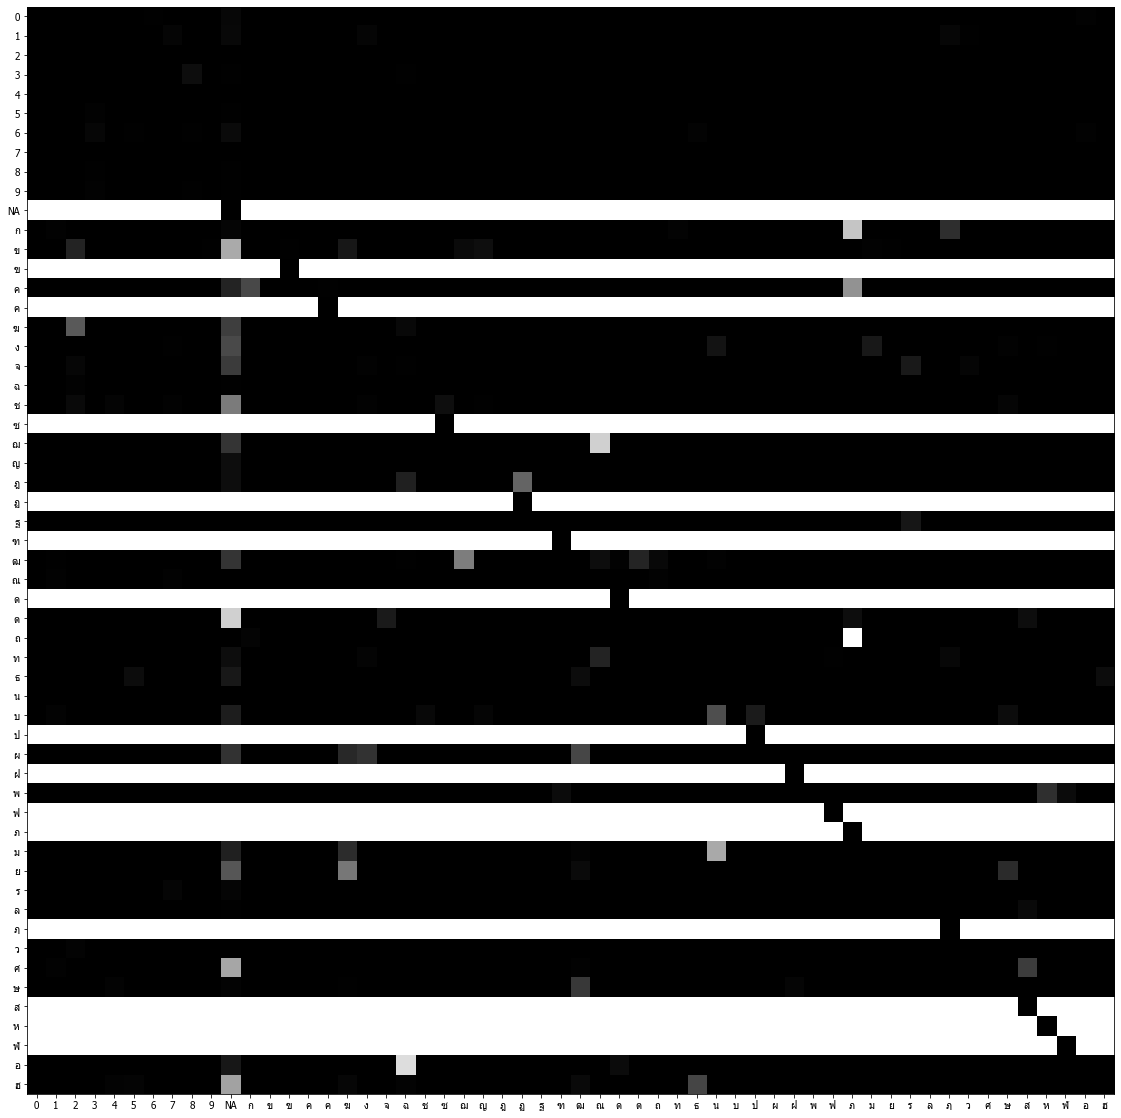

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
%matplotlib inline

gts_dets = np.array([[gt['label'], gt['predict']] for _, single_image_ground_truths in all_images_ground_truths.items() for gt in single_image_ground_truths])

labels = set(gts_dets[:, 0])
labels.update(gts_dets[:, 1])
labels = sorted(list(labels))
le = LabelEncoder()
le.fit(labels)

conf_mx = confusion_matrix(gts_dets[:, 0], 
                           gts_dets[:, 1], 
                           labels=labels)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize=(20,20))
plt.imshow(norm_conf_mx, cmap='gray')
plt.xticks(np.arange(len(labels)), labels=labels, family='Tahoma')
plt.yticks(np.arange(len(labels)), labels=labels, family='Tahoma')
plt.show()


### Draw Result

In [ ]:
def draw_detection(out_dir, image_path, detections, font, display_label=True):
    image_name = os.path.basename(image_path).split('.')[0]
    
    cleaned_image = Image.open(image_path)
    if cleaned_image.mode != 'RGB':
        cleaned_image = cleaned_image.convert('RGB')
    cleaned_image_drawer = ImageDraw.Draw(cleaned_image)    
    
    for det in detections:
        label = det['label']
        xmin, ymin, xmax, ymax = det['box']
        cleaned_image_drawer.line([(xmin, ymin), 
                                   (xmax, ymin),
                                   (xmax, ymax),
                                   (xmin, ymax),
                                   (xmin, ymin)], fill=(255, 0, 0), width=2)
        if display_label:
            cleaned_image_drawer.text((xmin + (xmax - xmin) / 2, ymax), label, fill=(255,0,0), font=font)
    cleaned_image.save(os.path.join(out_dir, f'{image_name}.jpg'))

# Define font
font_path = '/notebooks/projects/object-detection/models/research/object_detection/utils/fonts/angsa.ttf'
font = ImageFont.truetype(font_path, 18)


In [ ]:
# Draw True Positive
correct_detection_dir = os.path.join(TEST_RESULT_DIR, 'correct_detection')
if not os.path.exists(correct_detection_dir):
    os.makedirs(correct_detection_dir)
    
for image_name, single_image_detections in all_images_detections.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    detections_to_draw = [detection for detection in single_image_detections if detection['label'] == detection['actual']]
    if len(detections_to_draw) > 0:
        draw_detection(correct_detection_dir, image_path, detections_to_draw, font)

In [ ]:
# Draw False Positive
wrong_detection_dir = os.path.join(TEST_RESULT_DIR, 'wrong_detection')
#if not os.path.exists(wrong_detection_dir):
#    os.makedirs(wrong_detection_dir)
    
for image_name, single_image_detections in all_images_detections.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    wrong_detections = [detection for detection in single_image_detections if detection['label'] != detection['actual']]
    if len(wrong_detections) > 0:
        for wrong_detection in wrong_detections:
            if wrong_detection['actual'] == 'NA':
                out_dir = os.path.join(wrong_detection_dir, 'NA')
            else:
                out_dir = os.path.join(wrong_detection_dir, str(ord(wrong_detection['actual'])), str(ord(wrong_detection['label'])))
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            draw_detection(out_dir, image_path, [wrong_detection], font)

In [ ]:
wrong_detection

In [ ]:
# Draw False Negative
undetected_dir = os.path.join(TEST_RESULT_DIR, 'undetected')

for image_name, single_image_ground_truths in all_images_ground_truths.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    gts_to_draw = [gt for gt in single_image_ground_truths if gt['predict'] == 'NA']
    if len(gts_to_draw) > 0:
        for gt in gts_to_draw:
            out_dir = os.path.join(undetected_dir, str(ord(gt['label'])))
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            draw_detection(out_dir, image_path, [gt], font, display_label=False)

In [ ]:
# Draw All Detection
all_detections_dir = os.path.join(TEST_RESULT_DIR, 'all_detection')
if not os.path.exists(all_detections_dir):
    os.makedirs(all_detections_dir)
for image_name, single_image_detections in all_images_detections.items():
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_name + '.jpg')
    draw_detection(all_detections_dir, image_path, single_image_detections, font) 